In [1]:
# For files e data manipulations
from neuralNetwork import *

Working Well


## Neural Network

In [2]:
pnn = PreNeuralNetwork()

In [21]:
# dir_train = 'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive/train'
# dir_test  = 'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive/test'
# dir_valid = 'C:/Users/Lucas/Documents/PIBIC/DATASET/NIH-CHEST/archive/validation'
dir_train = 'C:/Users/Lucas/PIBIC/new_dir_train'
dir_test  = 'C:/Users/Lucas/PIBIC/new_dir_test'
dir_valid = 'C:/Users/Lucas/PIBIC/new_dir_valid'

batch_size = 32
width = 224
length = 224
channel = 3
image_size = (width, length)
random.seed(123) 

Como está dando o CLOCK_WATCHDOG_TIMEOUT reduzirei a quantidade de imagens

In [22]:
train_datagen= ImageDataGenerator(rescale=1.0/255)
val_datagen  = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator=train_datagen.flow_from_directory(dir_train,
                                        target_size=image_size,
                                        color_mode='rgb',  # Ensure RGB color mode
                                        class_mode='categorical',  # Adjust class_mode as needed
                                        batch_size=batch_size,
                                        subset='training'  # Specify 'training' for the training set
                                    )

val_generator=val_datagen.flow_from_directory(dir_valid,
                                        target_size=image_size,
                                        color_mode='rgb',
                                        class_mode='categorical',
                                        batch_size=batch_size
                                    )

test_generator=test_datagen.flow_from_directory(dir_test,
                                        target_size=image_size,
                                        color_mode='rgb',
                                        class_mode='categorical',
                                        batch_size=batch_size
                                    )

Found 900 images belonging to 9 classes.
Found 45 images belonging to 9 classes.
Found 45 images belonging to 9 classes.


In [23]:
n_classes = train_generator.num_classes
print("Number of classes:", n_classes)

Number of classes: 9


In [24]:
# Assuming you have a GPU with index 0
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Specify GPU device
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)


if tf.test.is_gpu_available():
    print("GPU is available and accessible.")
else:
    print("GPU is not available.")


GPU is not available.


In [25]:
# Create an instance of ResNet101Model
num_classes = n_classes  # Adjust the number of classes as needed
image_shape = (width,length,channel)  # Adjust image dimensions as needed
model = EfficientNetModelB7(num_classes, image_shape)

# Train the model
history = model.train(train_generator, val_generator, epochs=5, batch_size=batch_size, early_stop_patience=5)

Epoch 1/5
29/29 [==============================] - 110s 3s/step - loss: 2.6984 - accuracy: 0.1144 - val_loss: 2.7506 - val_accuracy: 0.1111
Epoch 2/5
29/29 [==============================] - 95s 3s/step - loss: 2.2502 - accuracy: 0.1022 - val_loss: 2.4629 - val_accuracy: 0.1111
Epoch 3/5
29/29 [==============================] - 95s 3s/step - loss: 2.2538 - accuracy: 0.1189 - val_loss: 2.4548 - val_accuracy: 0.1111
Epoch 4/5
29/29 [==============================] - 97s 3s/step - loss: 2.2524 - accuracy: 0.1156 - val_loss: 2.2844 - val_accuracy: 0.1111
Epoch 5/5
29/29 [==============================] - 97s 3s/step - loss: 2.2660 - accuracy: 0.0978 - val_loss: 2.3281 - val_accuracy: 0.0889


In [26]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)

2/2 [==============================] - 5s 1s/step - loss: 2.3259 - accuracy: 0.0889


In [27]:
df_results = model.create_metrics_dataframe(history)
df_results

,epoch,train_loss,val_loss,train_accuracy,val_accuracy
0,1,2.698406,2.750625,0.114444,0.111111
1,2,2.250162,2.462895,0.102222,0.111111
2,3,2.253837,2.454827,0.118889,0.111111
3,4,2.252445,2.284406,0.115556,0.111111
4,5,2.266049,2.328089,0.097778,0.088889


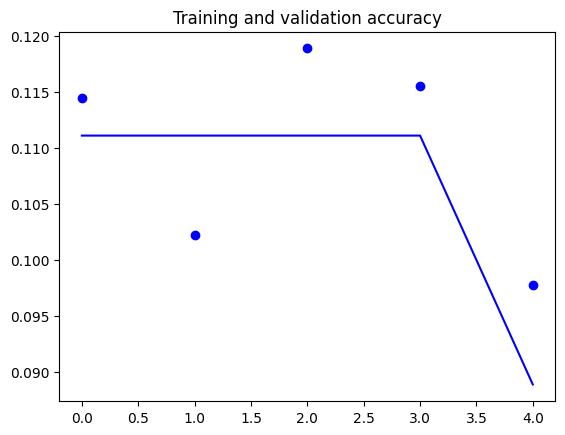

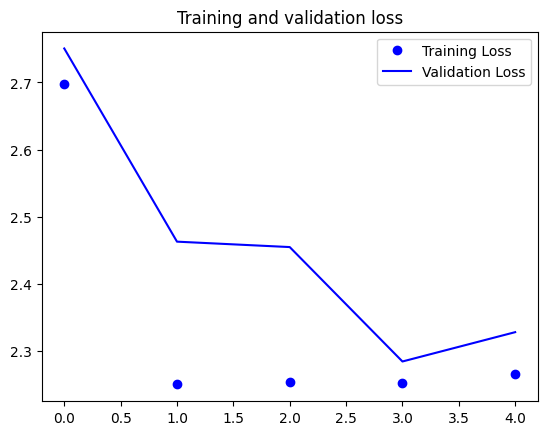

In [28]:
model.plot_history(history)

In [ ]:
# full_model.compile(loss='sparse_categorical_crossentropy',
#               optimizer=RMSprop(lr=1e-4),
#               metrics=['accuracy'])

In [ ]:
# # Checkpoint
# checkpoint = tf.keras.callbacks.ModelCheckpoint(f'model_NIG-CHEST/model_vgg_{qntd_for_model}_1.h5', 
#                                                 verbose = 1, 
#                                                 save_best = True, 
#                                                 save_weights_only = True)

# # Early stop
# early_stop = tf.keras.callbacks.EarlyStopping(patience = 4) 